# **Inference**

## **Importing Libraries**

In [37]:
from sklearn.metrics import confusion_matrix, recall_score, classification_report
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import os

## **Collect Data**

### **Test**

In [38]:
lung_test = None

test_path = os.path.join(os.getcwd(), "datasets/lung_survey_test.csv")

if os.path.isfile(test_path):
    lung_test = pd.read_csv(test_path)
    print("Dataset found locally.")

else:
    print("Dataset not found. Trying to access files online...")
    lung_test = pd.read_csv("https://raw.githubusercontent.com/crbsdndr/cancer_detection/refs/heads/main/datasets/lung_survey_test.csv")

    os.makedirs("datasets", exist_ok=True)
    lung_test.to_csv(test_path, index=False)
    print(f"Dataset successfully saved at: {test_path}")

Dataset found locally.


### **Synthetics**

In [39]:
lung_synthetics = None

synthetics_path = os.path.join(os.getcwd(), "datasets/lung_survey_synthetics.csv")

if os.path.isfile(synthetics_path):
    lung_synthetics = pd.read_csv(synthetics_path)
    print("Dataset found locally.")

else:
    print("Dataset not found. Trying to access files online...")
    lung_synthetics = pd.read_csv("https://raw.githubusercontent.com/crbsdndr/cancer_detection/refs/heads/main/datasets/lung_survey_synthetics.csv")

    os.makedirs("datasets", exist_ok=True)
    lung_synthetics.to_csv(synthetics_path, index=False)
    print(f"Dataset successfully saved at: {synthetics_path}")

Dataset found locally.


## **Preprocessing**

### **Setting Up**

In [40]:
def format_(*, dataset):
    dataset_copy = dataset.copy()

    dataset_copy.columns = [column.strip().lower().replace(" ", "_") for column in dataset_copy.columns]
    print("Success")

    return dataset_copy

def drop_duplicates_(*, dataset):
    dataset_copy = dataset.copy()
    dataset_copy.drop_duplicates(inplace=True)
    dataset_copy.reset_index(drop=True, inplace=True)

    print(f"Total duplicates after drop: {dataset_copy.duplicated().sum()}")

    return dataset_copy

def scale(*, dataset, column_):
    dataset_copy = dataset.copy()

    scaler = MinMaxScaler()

    dataset_copy[column_] = scaler.fit_transform(dataset_copy[[column_]])

    print(f"Column {column_} succesfully scaled in the given dataset.")

    return scaler, dataset_copy

def encoding(*, dataset, column_):
    dataset_copy = dataset.copy()
    
    label_encoder = LabelEncoder()
    dataset_copy[column_] = label_encoder.fit_transform(dataset_copy[column_])

    print(f"Column {column_} succesfully encoded in the given dataset.")
    return label_encoder, dataset

### **Clean Data**

In [41]:
lung_cleaned_test = lung_test.copy()

lung_cleaned_test = drop_duplicates_(dataset=lung_cleaned_test)

Total duplicates after drop: 0


### **Scaling**

In [42]:
lung_scaled_test = lung_cleaned_test.copy()

scaler, _ = scale(dataset=lung_synthetics, column_="AGE")
lung_scaled_test["AGE"] = scaler.transform(lung_scaled_test[["AGE"]])

Column AGE succesfully scaled in the given dataset.


### **Encoding**

In [43]:
lung_encoded_test = lung_scaled_test.copy()

encoder, lung_encoded_synthetics = encoding(dataset=lung_synthetics, column_="LUNG_CANCER")
lung_encoded_test["LUNG_CANCER"] = encoder.transform(lung_encoded_test["LUNG_CANCER"])

Column LUNG_CANCER succesfully encoded in the given dataset.


### **Action from Data Exploration**

In [44]:
lung_explored_test = lung_encoded_test.copy()

lung_explored_test.drop(
    columns=["GENDER"], inplace=True
)

### **Format Data**|

In [45]:
lung_formatted_test = format_(dataset=lung_explored_test)

Success


## **Evaluate**

### **Setting Up**

In [46]:
plt.style.use("dark_background")

In [47]:
def evaluate_model(*, model, x_test, y_test):
    y_prediction_probability = model.predict(x_test, verbose=0)

    y_prediction = (y_prediction_probability > 0.5).astype(int)

    test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=1)[:2]

    report_dict = classification_report(y_test, y_prediction, output_dict=True, zero_division=0)
    recall_score = report_dict["weighted avg"]["recall"]

    conf_matrix = confusion_matrix(y_test, y_prediction)

    results = {
        "probability": y_prediction_probability,
        "accuracy": test_accuracy,
        "recall": recall_score,
        "loss": test_loss,
        "confusion_matrix": conf_matrix
    }
    return results

def plot_evaluation_results(results, class_names=None):
    conf_matrix = results["confusion_matrix"]
    accuracy = results["accuracy"]
    recall = results["recall"]
    loss = results["loss"]

    if class_names is None:
        class_names = [str(i) for i in range(conf_matrix.shape[0])]

    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    sns.heatmap(
        conf_matrix, annot=True, fmt='d', cmap="Blues",
        xticklabels=class_names, yticklabels=class_names, ax=axes[0]
    )
    axes[0].set_xlabel("Predicted Labels")
    axes[0].set_ylabel("True Labels")
    axes[0].set_title("Confusion Matrix")

    metric_names = ["Accuracy", "Recall", "Loss"]
    metric_values = [accuracy, recall, loss]
    colors = ["skyblue", "lightgreen", "lightcoral"]
    axes[1].bar(metric_names, metric_values, color=colors)
    axes[1].set_ylim(0, 1)
    axes[1].set_title("Model Evaluation Metrics")

    plt.tight_layout()
    plt.show()

### **Load Model**

In [48]:
MODEL_PATH = "models/cancer_detection_model.keras"
loaded_model = tf.keras.models.load_model(MODEL_PATH)

### **Data Splitting**

In [49]:
x = lung_formatted_test.drop(columns="lung_cancer")
y = lung_formatted_test["lung_cancer"]

### **Evaluation Result**

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.8645 - auc: 0.8645 - loss: 2.4295 - precision_at_recall80: 0.8645  


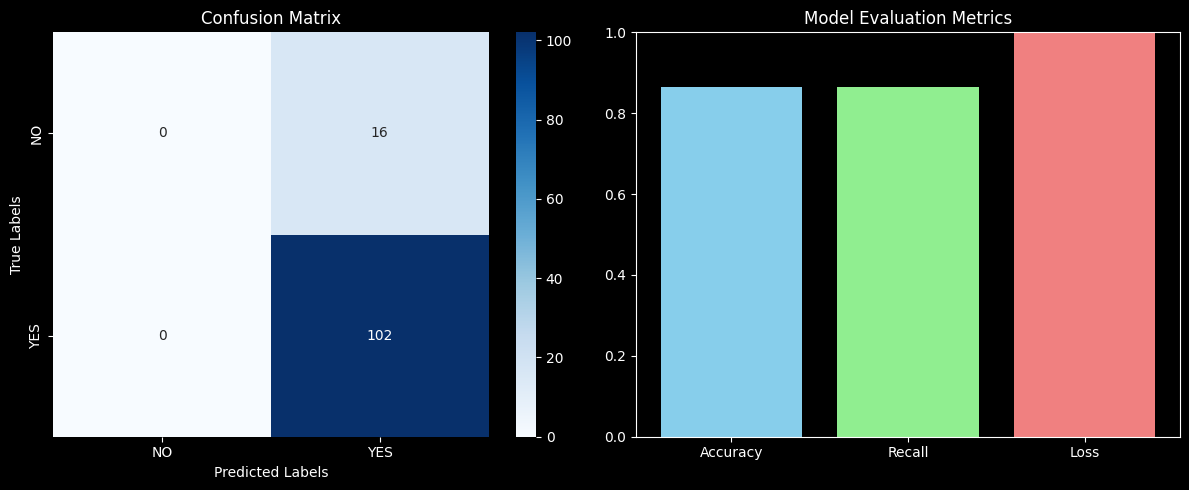

In [50]:
plot_evaluation_results(
    results=evaluate_model(model=loaded_model, x_test=x, y_test=y),
    class_names=np.unique(lung_encoded_synthetics["LUNG_CANCER"])
)